In [1]:
import pandas as pd
import pdb
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
#from sklearn.manifold import MDS 
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import NearestNeighbors
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [2]:
data  = pd.read_csv("data/featureslogfile_Budget_500_vs_Budget_500_GPM500_SD_NoSelfPlay.txt", sep = '\t')
#data  = pd.read_csv("data/2Player_FG1E_Supply_AllYears_Traces.txt", sep = ' ')
print(data)
print(data.columns)

        GameID  Player  Round  Turn  CurrentScore  SCORE  SCORE_ADV  ORDINAL  \
0          2.0     0.0    0.0   0.0           3.0   0.06       0.00      0.5   
1          2.0     1.0    0.0   0.0           3.0   0.06       0.00      0.5   
2          2.0     0.0    0.0   1.0           3.0   0.06       0.00      0.5   
3          2.0     1.0    0.0   1.0           3.0   0.06       0.00      0.5   
4          2.0     0.0    1.0   0.0           3.0   0.06       0.00      0.5   
...        ...     ...    ...   ...           ...    ...        ...      ...   
117445  1000.0     1.0   27.0   0.0          48.0   0.96      -0.52      1.0   
117446  1000.0     0.0   27.0   1.0          60.0   1.20       0.48      0.5   
117447  1000.0     1.0   27.0   1.0          48.0   0.96      -0.48      1.0   
117448  1000.0     0.0   28.0   0.0          61.0   1.22       0.52      0.5   
117449  1000.0     1.0   28.0   0.0          48.0   0.96      -0.52      1.0   

        OUR_TURN  HAS_WON  ...  SENTRY 

In [3]:
data = data[data['GameID']!=1000]

In [4]:
#LOGS_FROM_TAG = False #if false, logs are from parsed online player logs
LOGS_FROM_TAG = True

#choose whether or not to normalise playtraces so that each vector has a length of one
USE_UNIT_VECTOR_PLAYTRACES = False

#choose whether to make each deck vector entry between zero and one
USE_UNIT_CARD_COUNTS = False

#decide whether or not to remove outliers
REMOVE_OUTLIERS = True

NOOFPLAYERS = 2 #note, keep this fixed and dont change it - we always assume there are only two players
#agents = ['BMWG', 'DW']
agents = ['MCTS_Medium_A', 'MCTS_Medium_B'] #arbitrary labels for players (whether AI based or not)
#agents = ['PlayerA', 'PlayerB']

#if using TAG, parameters for round robin tournament
games_per_matchup = 500
self_play = False
#NoOfGames = 2 * games_per_matchup
NoOfGames = len(data['GameID'].unique())
if self_play == True:
    NoOfGames = 4 * games_per_matchup
    
#if not using TAG, determine no of games 
if LOGS_FROM_TAG == False:
    NoOfGames = data['GameID'].max()  + 1 #GameID starts at zero

In [5]:
#define columns of interest 
#card_types_BigMoneyWithGardens_vs_DoubleWitch = ['GARDENS', 'WITCH', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_SD = ['ARTISAN', 'BANDIT', 'BUREAUCRAT', 'CHAPEL', 'FESTIVAL', 'GARDENS', 'SENTRY', 'THRONE_ROOM', 'WITCH',
                 'WORKSHOP', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_FG1E = ['CELLAR','MARKET','MILITIA','MINE','MOAT','REMODEL','SMITHY','VILLAGE',
                'WOODCUTTER','WORKSHOP', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_BigMoneyWithGardens_vs_DoubleWitch = ['GARDENS', 'WITCH', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
#card_types_SD_reduced = ['GARDENS', 'WORKSHOP','PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_SD_reduced = ['CURSE']
#card_types = card_types_SD_reduced 
#card_types = card_types_FG1E
card_types = card_types_SD
index_cols = ['Player', 'GameID'] #used to group traces
non_card_types_round_indep_cols = ['AgentName', 'Win', 'FinalScore', 'TotalRounds'] #additional round indepedent values we want to investigate
cols = index_cols + non_card_types_round_indep_cols + ['Round'] + card_types #final set of cols to keep

In [6]:
#label all games with corresponding agent names

if LOGS_FROM_TAG == True:
    #first generate match-ups
    matchups = []
    if self_play:
        for agent1 in agents:
            for agent2 in agents:
                matchups.append((agent1, agent2))
    else:
        matchups = list(itertools.permutations(agents, 2))

    #function to map gameID to match-up
    def gameID_to_matchup(game_id, player_no, matchup_list, no_games_per_matchup, min_game_id):
        game_group = int((game_id - min_game_id)/no_games_per_matchup)
        matchup = matchup_list[game_group]
        agent1, agent2 = matchup
        if player_no == 0:
            return agent1
        else:
            return agent2

    #add agent names to data set
    min_GameID = data['GameID'].min()
    data['AgentName'] = data.apply(lambda row: gameID_to_matchup(row['GameID'], row['Player'], matchups, games_per_matchup, min_GameID), axis = 1)                         

In [7]:
#we can only record events each turn so we need to use the final turn in each round for each player to determine their
#deck at the end of the round
if LOGS_FROM_TAG:
    print(data['Turn'].unique())
    data = data[data['Turn'] == 1]

[0. 1.]


In [8]:
#all play taces in a single data frame
traces = data.loc[:, cols]
print(traces)

        Player  GameID      AgentName  Win  FinalScore  TotalRounds  Round  \
2          0.0     2.0  MCTS_Medium_A  1.0        44.0         23.0    0.0   
3          1.0     2.0  MCTS_Medium_B  0.0        28.0         23.0    0.0   
6          0.0     2.0  MCTS_Medium_A  1.0        44.0         23.0    1.0   
7          1.0     2.0  MCTS_Medium_B  0.0        28.0         23.0    1.0   
10         0.0     2.0  MCTS_Medium_A  1.0        44.0         23.0    2.0   
...        ...     ...            ...  ...         ...          ...    ...   
117245     1.0   999.0  MCTS_Medium_A  1.0        45.0         25.0   23.0   
117248     0.0   999.0  MCTS_Medium_B  0.0        41.0         25.0   24.0   
117249     1.0   999.0  MCTS_Medium_A  1.0        45.0         25.0   24.0   
117252     0.0   999.0  MCTS_Medium_B  0.0        41.0         25.0   25.0   
117253     1.0   999.0  MCTS_Medium_A  1.0        45.0         25.0   25.0   

        ARTISAN  BANDIT  BUREAUCRAT  ...  THRONE_ROOM  WITCH  W

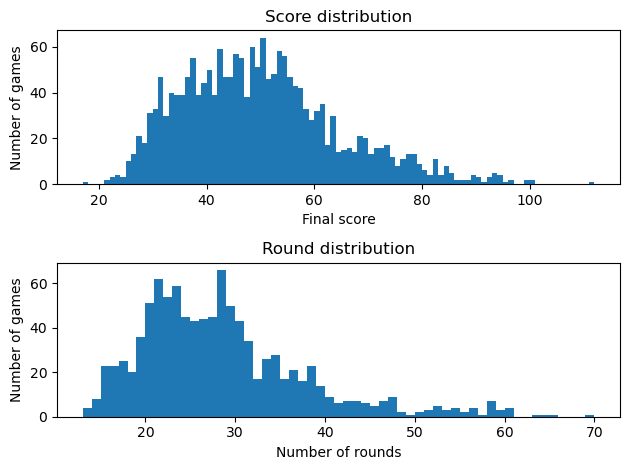

In [9]:
#plot score and round distributions
fig, axs = plt.subplots(2, 1)
grouped_data = traces.groupby('GameID')
score_data = grouped_data['FinalScore'].unique().explode()
axs[0].hist(score_data, bins=np.arange(score_data.min(), score_data.max()+1))
axs[0].set_xlabel('Final score')
axs[0].set_ylabel('Number of games')
axs[0].set_title('Score distribution')
round_data = traces.groupby('GameID')['Round'].max()
axs[1].hist(round_data, bins=np.arange(round_data.min(), round_data.max()+1))
axs[1].set_xlabel('Number of rounds')
axs[1].set_ylabel('Number of games')
axs[1].set_title('Round distribution')
fig.tight_layout() 

No traces before outlier removal: 58056
No traces after outlier removal: 53244
Percentage remaining of original data set: 0.9171145101281521


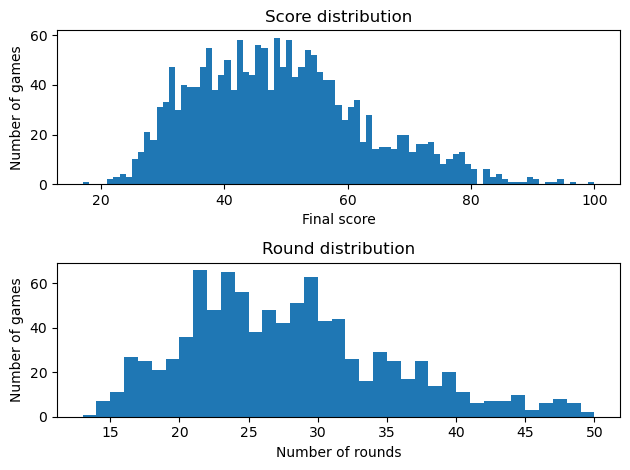

In [10]:
#remove outliers based on thresholds for score and length of game
#score_threshold = 80
#round_threshold = 46
score_threshold = 300
round_threshold = 50
traces_no_outliers = traces[(traces['FinalScore'] <= score_threshold)
                                           & (traces['TotalRounds'] <= round_threshold)]
#then re-plot score and round distributions
fig, axs = plt.subplots(2, 1)
grouped_data = traces_no_outliers.groupby('GameID')
score_data = grouped_data['FinalScore'].unique().explode()
axs[0].hist(score_data, bins=np.arange(score_data.min(), score_data.max()+1))
axs[0].set_xlabel('Final score')
axs[0].set_ylabel('Number of games')
axs[0].set_title('Score distribution')
round_data = grouped_data['TotalRounds'].unique().explode()
axs[1].hist(round_data, bins=np.arange(round_data.min(), round_data.max()+1))
axs[1].set_xlabel('Number of rounds')
axs[1].set_ylabel('Number of games')
axs[1].set_title('Round distribution')
fig.tight_layout() 

print("No traces before outlier removal: " + str(len(traces)))
print("No traces after outlier removal: " + str(len(traces_no_outliers)))
print("Percentage remaining of original data set: " + str(len(traces_no_outliers)/(1.0*len(traces)))) 

In [11]:
if REMOVE_OUTLIERS:
    traces = traces_no_outliers
    NoOfGames = len(traces['GameID'].unique())

In [12]:
#we need to make sure all games have the same number of rounds in them
gameLengths = traces.groupby(['GameID'])['Round'].max()
maxNoOfRounds = int(gameLengths.max()) + 1 #round counter starts at zero
print(maxNoOfRounds)

50


In [13]:
def copy_final_deck_at_game_end(group, roundMax, noPlayers):
    #This function repeatedly copies the final decks of two players at the game end, so that the game is extended to 
    #have roundMax rounds
    final_round = int(group['Round'].max())
    if (roundMax-1) == final_round:
        #in this case we dont need to extend the play trace
        return group
    else:
        final_row_copy = pd.concat([group.iloc[-noPlayers:]] * ((roundMax-1) - final_round), ignore_index=True)
        #we need to update the Round counter so that every other row it increments by one
        final_row_copy['Round'] = [final_round + 1 + i // 2 for i in range(((roundMax-1) - final_round)*2)]
        return pd.concat([group, final_row_copy], ignore_index=True)

In [14]:
extended_traces = traces.groupby('GameID').apply(copy_final_deck_at_game_end, maxNoOfRounds, NOOFPLAYERS).reset_index(drop = True)
print(extended_traces)
print("Expected no rows: " + str(maxNoOfRounds*NOOFPLAYERS*NoOfGames))
print("Expected no of cols: " + str(len(card_types)+7))
print(extended_traces.shape)

       Player  GameID      AgentName  Win  FinalScore  TotalRounds  Round  \
0         0.0     2.0  MCTS_Medium_A  1.0        44.0         23.0    0.0   
1         1.0     2.0  MCTS_Medium_B  0.0        28.0         23.0    0.0   
2         0.0     2.0  MCTS_Medium_A  1.0        44.0         23.0    1.0   
3         1.0     2.0  MCTS_Medium_B  0.0        28.0         23.0    1.0   
4         0.0     2.0  MCTS_Medium_A  1.0        44.0         23.0    2.0   
...       ...     ...            ...  ...         ...          ...    ...   
95595     1.0   999.0  MCTS_Medium_A  1.0        45.0         25.0   47.0   
95596     0.0   999.0  MCTS_Medium_B  0.0        41.0         25.0   48.0   
95597     1.0   999.0  MCTS_Medium_A  1.0        45.0         25.0   48.0   
95598     0.0   999.0  MCTS_Medium_B  0.0        41.0         25.0   49.0   
95599     1.0   999.0  MCTS_Medium_A  1.0        45.0         25.0   49.0   

       ARTISAN  BANDIT  BUREAUCRAT  ...  THRONE_ROOM  WITCH  WORKSHOP  CURS

In [15]:
#next if required we convert all entries ot values between zero and one
#to do this for each round we look at the maximum number of card tyoes for that round
#and divide all card amounts for that card type and for that round by the maximum

def normalise_card_counts(row, maxCardByType, cardTypes, maxRounds):
    for card in cardTypes:
        max_val = 1
        if maxCardByType[maxRounds-1][card] > 0:
            max_val = maxCardByType[maxRounds-1][card]
        row[card] = row[card]/max_val
    return row

max_card_by_type = {}
if USE_UNIT_CARD_COUNTS:
    for round_no in range(0, maxNoOfRounds):
        max_card_by_type[round_no] = {}
        for card in card_types:
            tmp = extended_traces[extended_traces['Round'] == round_no]
            max_card_by_type[round_no][card] = tmp[card].max()
            #pdb.set_trace()
    
    #next divide each card amount by the maximum value
    extended_traces = extended_traces.apply(lambda row: normalise_card_counts(row, max_card_by_type, card_types, maxNoOfRounds), axis = 1) 

In [16]:
#next we need to flatten this dataframe so that each trace is a single row.
#We also drop the round label as it is redundant
#and it will get reintroduced when flattening through the revised column names

#given a dictionary whose elements are lists of length two, grab the other element not given by elem, used in code
#below
def other_dict_element(my_dict, my_key, my_elem):
    index_of_given_element = my_dict[my_key].index(my_elem)
    index_of_other_element =  1 if (index_of_given_element == 0) else 0
    return my_dict[my_key][index_of_other_element]

#first create dataframe consisting of only non card type data types that are round 
#independent
non_card_data_round_indep = extended_traces[index_cols + non_card_types_round_indep_cols].drop_duplicates()

#next need to Group by Player and GameID and then flatten card data by round
traces_tmp = extended_traces[index_cols + card_types]
cols = [card_types[i] + "_R" + str(r) 
        for r in range(0, maxNoOfRounds) for i in range(0, len(card_types))] 

extended_traces_flat = traces_tmp.groupby(index_cols).apply(lambda df: df[card_types].values.flatten())
extended_traces_flat = pd.DataFrame(extended_traces_flat, columns = ['Trace']).reset_index()
extended_traces_flat = pd.concat([extended_traces_flat[index_cols], extended_traces_flat['Trace'].apply(pd.Series)], axis=1)
extended_traces_flat.columns = index_cols + cols

#next we add back in the round independent data
extended_traces_flat = pd.merge(non_card_data_round_indep, extended_traces_flat, on = index_cols)
                                 
#finally we also add the name of the agent of the opponent 
extended_traces_flat['Opponent'] = extended_traces_flat.apply(lambda row: 1.0 if row['Player'] == 0.0 else 0.0, axis = 1)
if LOGS_FROM_TAG:
    extended_traces_flat['AgentNameOpponent'] = extended_traces_flat.apply(lambda row: gameID_to_matchup(row['GameID'], row['Opponent'], matchups, games_per_matchup, min_GameID), axis = 1)  
else:
    gameid_to_players_dict = extended_traces_flat.groupby('GameID')['AgentName'].apply(list).to_dict()
    extended_traces_flat['AgentNameOpponent'] = extended_traces_flat.apply(lambda row: 
                            other_dict_element(gameid_to_players_dict, row['GameID'], row['AgentName']), axis = 1)   

In [17]:
#function to compare a pair of play traces
def deck_evol_comparison(trace_list, label_list, cardTypes, maxRounds, legendOn = True, ylimit = 0):
    #look at evolution of number of cards of each type per round
    noOfCardTypes = len(cardTypes)
    noOfSubPlotCols = 5
    noOfSubPlotRows = max(2, math.floor(noOfCardTypes/noOfSubPlotCols) + 1)
    fig, axs = plt.subplots(noOfSubPlotRows, noOfSubPlotCols, figsize = (10,10))
    for i in range(0,noOfSubPlotRows):
        for j in range(0,noOfSubPlotCols):
            cardIndex = noOfSubPlotRows*j + i
            if cardIndex >= len(cardTypes):
                axs[i,j].set_visible(False)
            else:
                cardType = cardTypes[cardIndex]
                card_col = [cardType + "_R" + str(r) for r in range(0,maxRounds)]
                card_max = 0
                for (index, trace) in enumerate(trace_list):
                    axs[i,j].plot(range(0,maxRounds), trace[card_col].iloc[0], label = label_list[index])
                    tmp_card_max = int(trace[card_col].iloc[0].max())
                    if tmp_card_max > card_max:
                        card_max = tmp_card_max
                
                #set labels and limits
                axs[i,j].set_title(cardType)
                axs[i,j].set_xlabel('Round')
                if ylimit == 0:
                    axs[i,j].set_ylim((0,card_max+2))
                else:
                    axs[i,j].set_ylim((0,1))
                #axs[i,j].set_ylim((0,card_max))
                axs[i,j].set_xticks(ticks = range(0, maxRounds,10))
            
            #tighten subplots layout
            fig.tight_layout() 
            
    #add overal legend to figure
    if legendOn:
        axs[0,noOfSubPlotRows - 1].legend(loc = (1.2,-0.8))

In [18]:
#function to support examining outliers, find a game wiht the max value of a particualr field
#and plots the traces of both players
def examine_outlier(fieldname, traces_data, flat_trace_data):
    grouped_data = traces_data.groupby('GameID')
    tmp_df = pd.DataFrame(grouped_data[fieldname].unique().explode())
    outlier_gameid = tmp_df[fieldname].astype('float').idxmax()
    outlier_trace_player0 = flat_trace_data[(flat_trace_data['GameID'] == outlier_gameid) & (flat_trace_data['Player'] == 0)]
    outlier_trace_player1 = flat_trace_data[(flat_trace_data['GameID'] == outlier_gameid) & (flat_trace_data['Player'] == 1)]
    print("Outlier gameID: " + str(outlier_gameid))

    trace_list = [outlier_trace_player0, outlier_trace_player1]
    label_list = ['Final score - ' + str(outlier_trace_player0['FinalScore'].iloc[0]),
                  'Final score - ' + str(outlier_trace_player1['FinalScore'].iloc[0])]
    deck_evol_comparison(trace_list, label_list, card_types, maxNoOfRounds)
    print(flat_trace_data[flat_trace_data['GameID'] == outlier_gameid])
    return outlier_gameid

In [19]:
#outlier_game_id = examine_outlier('CURSE', traces, extended_traces_flat)

In [20]:
#next we compute the average traces for each combination of players and opponents, this 
#allows us to compare to the centroids computed by k-means clustering (note this is only 
#useful when we know what strategies are being employed by our AI agents or players, and 
#is used to sense check K-means in our base case scenarios)

flat_trace_tmp = extended_traces_flat.drop(['Player','Opponent','GameID'], axis = 1)
average_traces = flat_trace_tmp.groupby(['AgentName','AgentNameOpponent']).apply(lambda row: round(row.mean())).reset_index()
new_col_names = {old_col: old_col + '_avg' for old_col in average_traces.columns[2:]}
average_traces.rename(columns = new_col_names, inplace = True)
print(average_traces)

       AgentName AgentNameOpponent  Win_avg  FinalScore_avg  TotalRounds_avg  \
0  MCTS_Medium_A     MCTS_Medium_B      0.0            48.0             27.0   
1  MCTS_Medium_B     MCTS_Medium_A      1.0            48.0             27.0   

   ARTISAN_R0_avg  BANDIT_R0_avg  BUREAUCRAT_R0_avg  CHAPEL_R0_avg  \
0             0.0            0.0                0.0            0.0   
1             0.0            0.0                0.0            0.0   

   FESTIVAL_R0_avg  ...  THRONE_ROOM_R49_avg  WITCH_R49_avg  WORKSHOP_R49_avg  \
0              0.0  ...                  0.0            0.0               2.0   
1              0.0  ...                  1.0            0.0               2.0   

   CURSE_R49_avg  PROVINCE_R49_avg  DUCHY_R49_avg  ESTATE_R49_avg  \
0            1.0               2.0            4.0             6.0   
1            1.0               2.0            4.0             6.0   

   GOLD_R49_avg  SILVER_R49_avg  COPPER_R49_avg  
0           3.0             7.0            10.

In [21]:
#calculate average distances and standard deviations of individual playtraces to the
#average playtraces

def dist_measure(playTracePair, cardTypes, maxRounds, tag1, tag2):
    dist = 0
    for r in range(0, maxRounds):
        for card in cardTypes:
            col1 = card + "_R" + str(r) + tag1
            col2 = card + "_R" + str(r) + tag2
            dist += (playTracePair[col1]-playTracePair[col2])**2
    dist = math.sqrt(dist)
    return dist

distances_to_avgs_dict = {}
mean_and_std_to_avgs_list = []
for avg_trace_label in matchups:
    player, opp = avg_trace_label
    avg_trace = average_traces[(average_traces['AgentName'] == player) 
                               & (average_traces['AgentNameOpponent'] == opp)].drop(['AgentName','AgentNameOpponent'], axis = 1)
    avg_trace = pd.concat([avg_trace]*len(extended_traces_flat), ignore_index = True)
    avg_trace.reset_index()
    extended_traces_flat.reset_index()
    trace_pairs_to_avg = pd.concat([extended_traces_flat, avg_trace], axis = 1)
    
    #now we can compute the distance
    trace_pairs_to_avg['dist'] = trace_pairs_to_avg.apply(lambda row: dist_measure(row, card_types, maxNoOfRounds, "", "_avg"), axis = 1)
    trace_pairs_to_avg = trace_pairs_to_avg[['AgentName', 'AgentNameOpponent','dist']]
    distances_to_avgs_dict[avg_trace_label] = trace_pairs_to_avg
    
    #calculate averages and standard deviations
    results = round(trace_pairs_to_avg.groupby(['AgentName', 'AgentNameOpponent']).agg(['mean','std','count']),1).reset_index()
    results.columns = ['AgentName', 'AgentNameOpponent', 'Mean', 'Std', 'Count']
    avg_trace_label_as_str = "Avg. " + str(player) + " (vs " + str(opp) + ")"
    results['Average Trace'] = [avg_trace_label_as_str] * len(results)
    results['Average Trace Label'] = [(player,opp)] * len(results)
    results = results.reindex(columns=['AgentName', 'AgentNameOpponent', 'Average Trace','Mean', 'Std', 'Count', 'Average Trace Label'])
    mean_and_std_to_avgs_list.append(results)  

#concatenate mean and std results for each matchup
mean_and_std_to_avgs = pd.concat(mean_and_std_to_avgs_list)
mean_and_std_to_avgs = mean_and_std_to_avgs.sort_values('Mean')
print(mean_and_std_to_avgs)

       AgentName AgentNameOpponent                          Average Trace  \
0  MCTS_Medium_A     MCTS_Medium_B  Avg. MCTS_Medium_A (vs MCTS_Medium_B)   
1  MCTS_Medium_B     MCTS_Medium_A  Avg. MCTS_Medium_A (vs MCTS_Medium_B)   
0  MCTS_Medium_A     MCTS_Medium_B  Avg. MCTS_Medium_B (vs MCTS_Medium_A)   
1  MCTS_Medium_B     MCTS_Medium_A  Avg. MCTS_Medium_B (vs MCTS_Medium_A)   

   Mean   Std  Count             Average Trace Label  
0  40.3  10.5    956  (MCTS_Medium_A, MCTS_Medium_B)  
1  40.3  10.9    956  (MCTS_Medium_A, MCTS_Medium_B)  
0  40.3  10.5    956  (MCTS_Medium_B, MCTS_Medium_A)  
1  40.3  10.9    956  (MCTS_Medium_B, MCTS_Medium_A)  


In [22]:
#prepare data for kmeans
tmp =  index_cols + non_card_types_round_indep_cols
tmp  = tmp + ['Opponent','AgentNameOpponent']
trace_X = extended_traces_flat.drop(tmp, axis = 1)

#alos create a normalised set pf playtraces 
def normalize_row(row):
    norm = np.linalg.norm(row)  # Compute the L2 norm of the row
    if norm != 0:
        return row / norm
    else:
        return row
    
trace_X_normalised = trace_X.apply(lambda row: normalize_row(row), axis = 1)

#choose whether or not to normalise playtraces
if USE_UNIT_VECTOR_PLAYTRACES:
    trace_X = trace_X_normalised

[1.         0.67772341 0.59993944 0.54896103 0.5123693  0.48501328
 0.46419402 0.44903805 0.43540906 0.42384379 0.41320397 0.40602664
 0.3995921  0.3927411  0.38746065 0.38123225 0.37569341 0.37213592
 0.36692258]


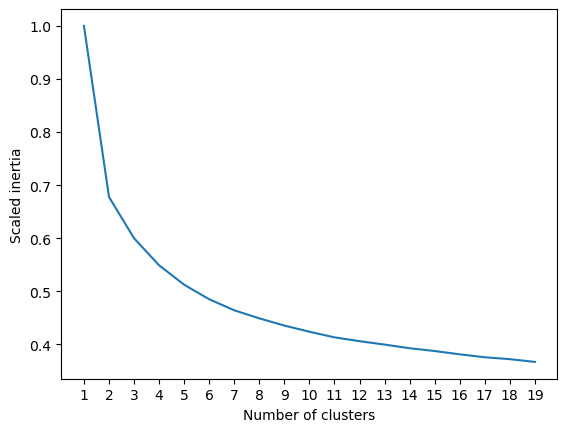

In [23]:
#inertia and elbow method
range_n_clusters = range(1, 20, 1)
inertia_vals = []
for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init= 'warn', max_iter=300, tol=0.0001,
                    verbose=0, random_state= 10, copy_x=True, algorithm='lloyd')
    cluster_labels = clusterer.fit_predict(trace_X)
    inertia_vals.append(clusterer.inertia_)

#scale the inertia vals so that the first value is one
inertia_vals = np.array(inertia_vals)/inertia_vals[0]

#plot as a line plot
plt.plot(range_n_clusters, inertia_vals)
plt.xticks(range_n_clusters)
plt.xlabel("Number of clusters")
plt.ylabel("Scaled inertia")

#output inertia values
print(inertia_vals)

For n_clusters = 2 The average silhouette_score is : 0.28417062647894636
For n_clusters = 3 The average silhouette_score is : 0.20697528930070877
For n_clusters = 4 The average silhouette_score is : 0.1799859826187721
For n_clusters = 5 The average silhouette_score is : 0.15087328367787023
For n_clusters = 6 The average silhouette_score is : 0.14674720942215352
For n_clusters = 7 The average silhouette_score is : 0.12226908978711064
For n_clusters = 8 The average silhouette_score is : 0.11928161462771583
For n_clusters = 9 The average silhouette_score is : 0.11256202005762048
For n_clusters = 10 The average silhouette_score is : 0.10763038794743159


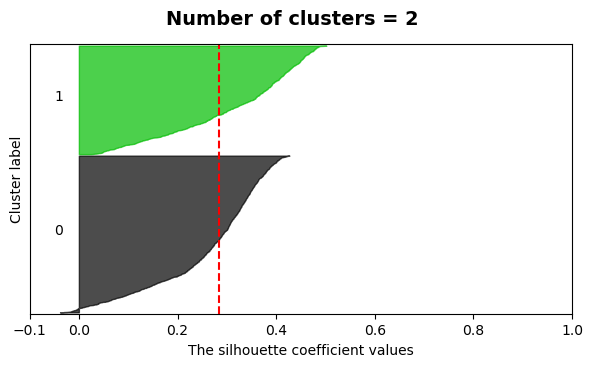

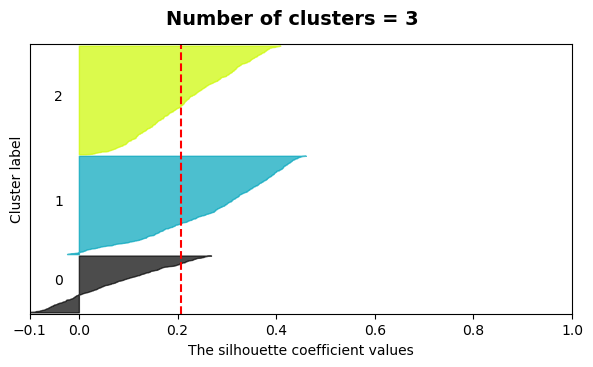

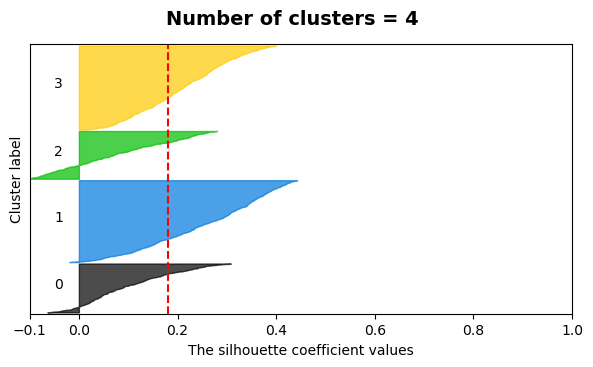

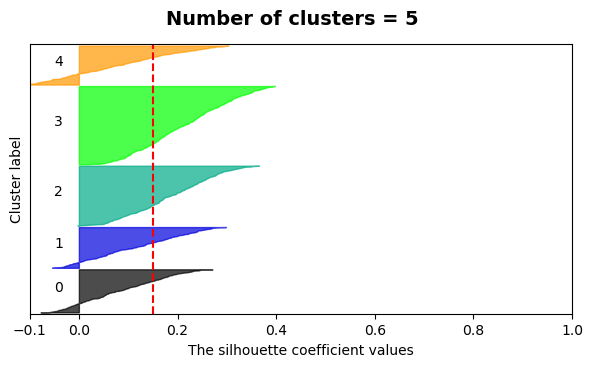

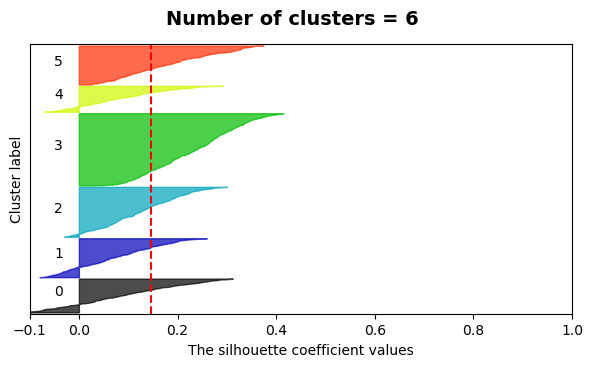

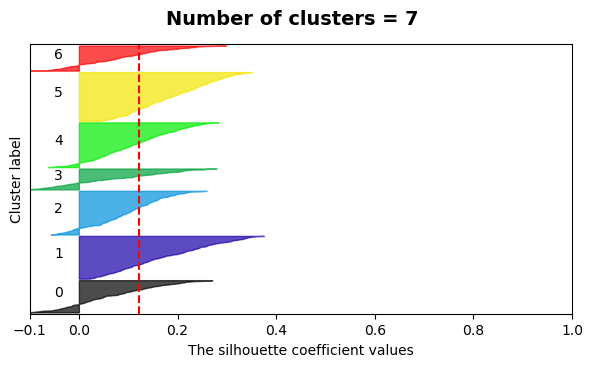

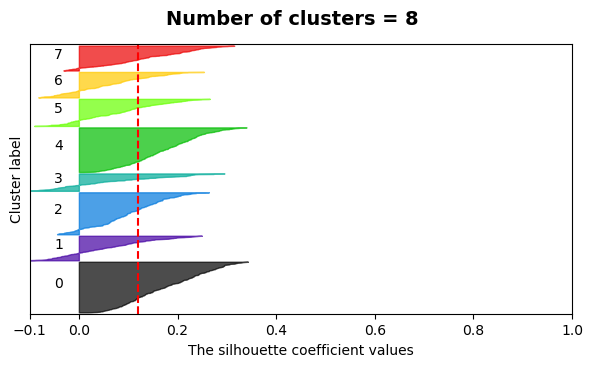

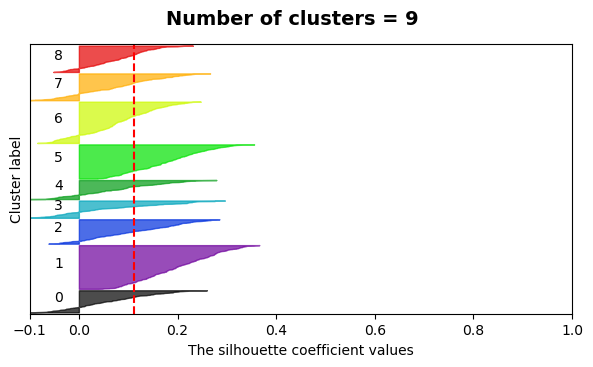

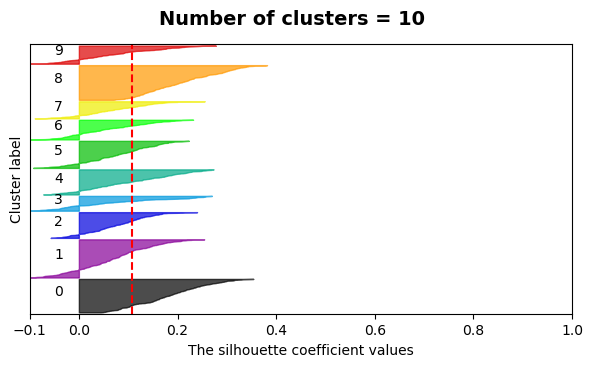

Text(0, 0.5, 'Silhouette Average')

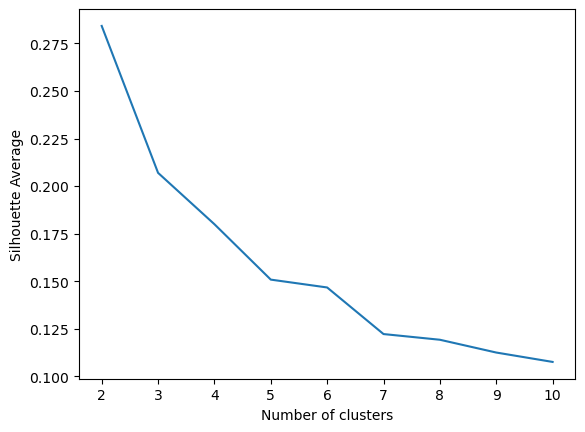

In [24]:
#next we consider three different methods for choosing the optimal number of clusters. If these dont perform well
#we will move onto the more complex approach of the gap statistic

#silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette_avg_list = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 1 columns
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(7, 3.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(trace_X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init= 'warn', max_iter=300, tol=0.0001,
                    verbose=0, random_state= 10, copy_x=True, algorithm='lloyd')
    #cluster_labels = clusterer.fit_predict(X)
    cluster_labels = clusterer.fit_predict(trace_X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(trace_X, cluster_labels)
    silhouette_avg_list.append(silhouette_avg)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(trace_X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.suptitle(
        #"Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        "Number of clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

#also we plot just the average silhouette values by cluster number
plt.plot(range_n_clusters, silhouette_avg_list)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Average")

In [25]:
#next we want to apply k-means clustering with (euclidean distance measure) on our set of traces 
num_clusters = 2 #this needs to be set as needed
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init= 'warn', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd').fit(trace_X)

In [26]:
#add kmeans cluster classifications of traces to dataframe 
extended_traces_flat['ClusterID'] = kmeans.labels_
strat_vs_clusterid = extended_traces_flat[['AgentName', 'AgentNameOpponent','ClusterID']]
counts = strat_vs_clusterid.groupby(['AgentName', 'AgentNameOpponent','ClusterID']).size()
print(counts)

AgentName      AgentNameOpponent  ClusterID
MCTS_Medium_A  MCTS_Medium_B      0            393
                                  1            563
MCTS_Medium_B  MCTS_Medium_A      0            389
                                  1            567
dtype: int64


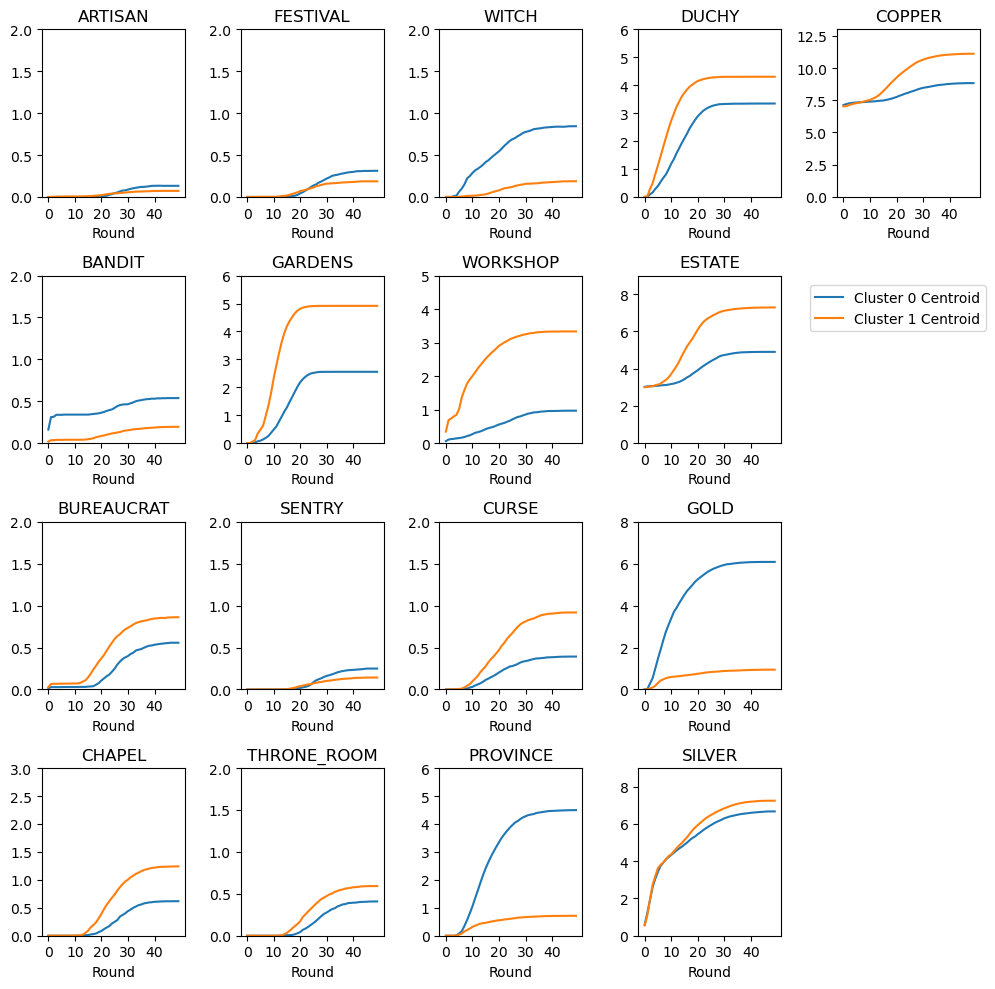

In [27]:
#compare centroids
df_cluster_centres = pd.DataFrame(kmeans.cluster_centers_)
cols = [card_types[i] + "_R" + str(r) for r in range(0, maxNoOfRounds) 
        for i in range(0, len(card_types))]
df_cluster_centres.columns = cols

def plot_cluster_centroids(no_of_clusters, cluster_centre_data, cardTypes, maxRounds, legendOn = True, ylimit = 0):
    trace_list = []
    label_list = []
    for n in range(0, no_of_clusters):
        trace_list.append(pd.DataFrame(cluster_centre_data.iloc[n]).transpose())
        label_list.append(str('Cluster ') + str(n) + str(' Centroid'))
    deck_evol_comparison(trace_list, label_list, cardTypes, maxRounds, legendOn, ylimit)

plot_cluster_centroids(num_clusters, df_cluster_centres, card_types, maxNoOfRounds)

In [55]:
#next we look at how the clustering changes based on increasing round number
num_clusters = 2
round_cut_centroids = {}
silhouette_averages = {}
cluster_list = [1,2,3,4,5,6,7,8]
round_cutoff_list = range(5, maxNoOfRounds, 5)
inertia_vals = {}
for no_clusters in cluster_list:
    round_cut_centroids[no_clusters] = {}
    silhouette_averages[no_clusters] = {}
    inertia_vals[no_clusters] = {}
    for round_cutoff in round_cutoff_list:
        #perform clustering on play traces cut at the round cut-off
        col_cutoff = 17 * round_cutoff
        trace_X_cut = trace_X.iloc[:, :col_cutoff]
        kmeans = KMeans(n_clusters=no_clusters, init='k-means++', n_init= 'warn', max_iter=300, tol=0.0001, verbose=0, random_state= 10, copy_x=True, algorithm='lloyd').fit(trace_X_cut)

        #collect and label cluster centroid
        df_cluster_centres = pd.DataFrame(kmeans.cluster_centers_)
        cols = [card_types[i] + "_R" + str(r) for r in range(0, round_cutoff) 
                for i in range(0, len(card_types))]
        df_cluster_centres.columns = cols

        #store centroids in a dictionary keyed by round cut_off
        round_cut_centroids[no_clusters][round_cutoff] = df_cluster_centres

        #also compute average silhouette score by round cutoff
        cluster_labels = kmeans.fit_predict(trace_X_cut)
        if no_clusters == 1:
            silhouette_averages[no_clusters][round_cutoff] =  0
        else:
            silhouette_averages[no_clusters][round_cutoff] = silhouette_score(trace_X_cut, cluster_labels)   
        
        #finally compute inertia values also
        inertia_vals[no_clusters][round_cutoff] = kmeans.inertia_

#scale the inertia vals so that the first value is one
cluster_list_reversed = cluster_list[::-1]
for no_clusters in cluster_list_reversed:
    for round_cutoff in round_cutoff_list:
        inertia_vals[no_clusters][round_cutoff] = inertia_vals[no_clusters][round_cutoff]/inertia_vals[1][round_cutoff]


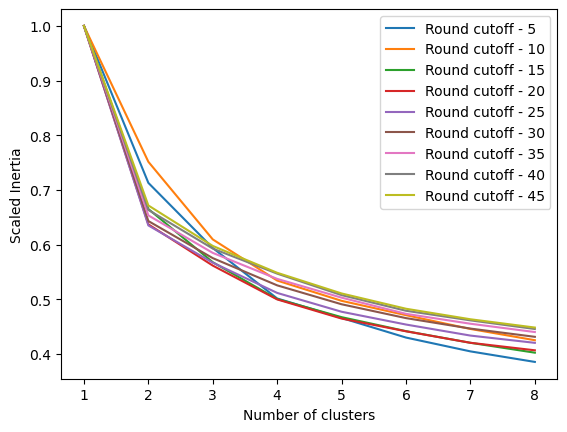

In [60]:
#plot inertia elbows
for rounds in round_cutoff_list:
    xvals = [r for r in inertia_vals.keys()]
    yvals = [inertia_vals[c][rounds] for c in cluster_list]
    plt.plot(xvals, yvals, label = 'Round cutoff - ' + str(rounds))
plt.xlabel('Number of clusters')
plt.ylabel('Scaled Inertia')
plt.legend()


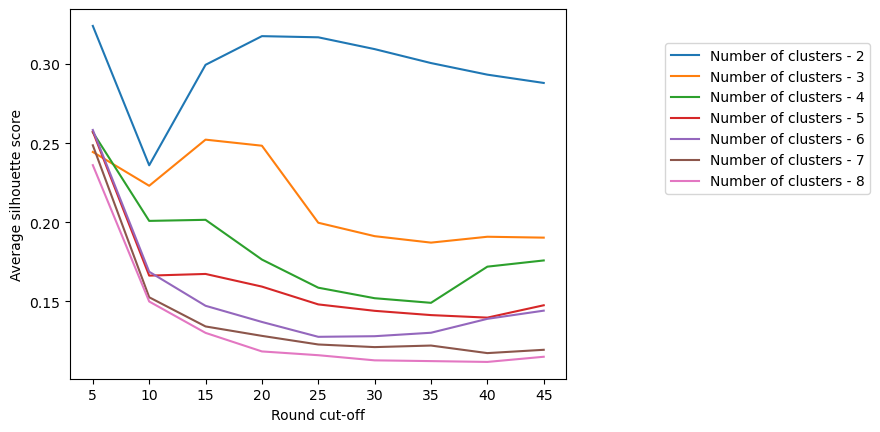

In [65]:
#plot silhouette averages
for no_clusters in cluster_list:
    if no_clusters != 1:
        rounds = [r for r in silhouette_averages[no_clusters].keys()]
        vals = [sa for sa in silhouette_averages[no_clusters].values()]
        plt.plot(rounds, vals, label = 'Number of clusters - ' + str(no_clusters))
plt.xlabel('Round cut-off')
plt.ylabel('Average silhouette score')
plt.legend(loc = (1.2,0.5))

In [ ]:
def plot_evol_varying_size(trace_list, label_list, cardTypes, legendOn = True):
    noOfCardTypes = len(cardTypes)
    noOfSubPlotCols = 5
    noOfSubPlotRows = max(2, math.floor(noOfCardTypes/noOfSubPlotCols) + 1)
    fig, axs = plt.subplots(noOfSubPlotRows, noOfSubPlotCols, figsize = (10,10))
    maxRounds = 0
    for i in range(0,noOfSubPlotRows):
        for j in range(0,noOfSubPlotCols):
            cardIndex = noOfSubPlotRows*j + i
            if cardIndex >= len(cardTypes):
                axs[i,j].set_visible(False)
            else:
                cardType = cardTypes[cardIndex]
                card_max = 0
                for (index, trace) in enumerate(trace_list):
                    #pdb.set_trace()
                    traceRounds = int(len(trace)/17)
                    card_col = [cardType + "_R" + str(r) for r in range(0,traceRounds)]
                    if traceRounds > maxRounds:
                        maxRounds = traceRounds
                    #pdb.set_trace()
                    axs[i,j].plot(trace[card_col], label = label_list[index])
                    tmp_card_max = int(trace[card_col].max())
                    if tmp_card_max > card_max:
                        card_max = tmp_card_max
                
                #set labels and limits
                axs[i,j].set_title(cardType)
                axs[i,j].set_xlabel('Round')
                axs[i,j].set_ylim((0,card_max+2))
                #axs[i,j].set_ylim((0,card_max))
                axs[i,j].set_xticks(ticks = range(0, maxRounds,10))
                axs[i,j].set_xticklabels(range(0, maxRounds,10))
            
            #tighten subplots layout
            fig.tight_layout() 
            
    #add overal legend to figure
    if legendOn:
        axs[0,noOfSubPlotRows - 1].legend(loc = (1.2,-0.8))

In [ ]:
trace_list = []
label_list = []
for round_cutoff in range(5, maxNoOfRounds, 5):
    trace_list.append(round_cut_centroids[round_cutoff].iloc[0])
    trace_list.append(round_cut_centroids[round_cutoff].iloc[1])
    label_list.append('Centroid 0 - round cutoff ' + str(round_cutoff))
    label_list.append('Centroid 1 - round cutoff ' + str(round_cutoff))

plot_evol_varying_size(trace_list, label_list, card_types)

In [ ]:
#for AI centroid player if needed
#df_cluster_centres_rounded = df_cluster_centres.round()
#print(df_cluster_centres_rounded)
#df_cluster_centres.iloc[0].to_json('FG1E_PlayerLogs_Centroid0.json', orient='columns')
#df_cluster_centres.iloc[1].to_json('FG1E_PlayerLogs_Centroid1.json', orient='columns')

In [ ]:
#compare centroids against DW centroid fed into centroid player algorithm
df_centroid_player = pd.read_json('data/FG1E_PlayerLogs_Centroid0.json', typ = 'series')
trace_list = [df_cluster_centres.iloc[0], df_cluster_centres.iloc[1], df_centroid_player]
label_list = ['Cluster Centroid 0', 'Cluster centroid 1', 'Input FG1E Player Centroid 1']
plot_evol_varying_size(trace_list, label_list, card_types)

In [ ]:
#plot a single cluster
cluster_no = 0
single_cluster = pd.DataFrame(df_cluster_centres.iloc[cluster_no]).transpose()
trace_list = [single_cluster]
label_list = ['cluster centroid']
deck_evol_comparison(trace_list, label_list, card_types, maxNoOfRounds)

In [ ]:
#which cluster does the outlier trace belong to? (assuming not been filtered out)
outlier_trace_player0 = extended_traces_flat[(extended_traces_flat['GameID'] == outlier_game_id) &
                                              (extended_traces_flat['Player'] == 0)]
outlier_trace_player1 = extended_traces_flat[(extended_traces_flat['GameID'] == outlier_game_id) &
                                              (extended_traces_flat['Player'] == 1)]

cluster_for_outlier_player0 = outlier_trace_player0['ClusterID'].iloc[0]
cluster_for_outlier_player1 = outlier_trace_player1['ClusterID'].iloc[0]
cluster_trace_for_player0 = pd.DataFrame(df_cluster_centres.iloc[cluster_for_outlier_player0]).transpose()
cluster_trace_for_player1 = pd.DataFrame(df_cluster_centres.iloc[cluster_for_outlier_player1]).transpose()
#pdb.set_trace()
trace_list = [cluster_trace_for_player0, cluster_trace_for_player1]
label_list = ['Cluster for player 0 of outlier game', 'Cluster for player 1 of outlier game']
deck_evol_comparison(trace_list, label_list, card_types, maxNoOfRounds)
print('Cluster for player 0 of outlier game: ' + str(cluster_for_outlier_player0))
print('Cluster for player 1 of outlier game: ' + str(cluster_for_outlier_player1))

def dist_measure_v2(trace1, trace2, cardTypes, maxRounds, useIndexing = True):
    dist = 0
    for r in range(0, maxRounds):
        for card in cardTypes:
            col = card + "_R" + str(r)
            if useIndexing:
                dist += (trace1[col].iloc[0] - trace2[col].iloc[0])**2
            else:
                dist += (trace1[col] - trace2[col])**2
    dist = math.sqrt(dist)
    return dist

#distance to cluster centroid
#for n in range(0,3):
#    cluster_trace = pd.DataFrame(df_cluster_centres.iloc[n]).transpose()
#    print(dist_measure_v2(cluster_trace, curse_trace, card_types, maxNoOfRounds))

In [ ]:
#plot player play trace against corresponding cluster
trace_list = [outlier_trace_player0, cluster_trace_for_player0]
label_list = ['Outlier - Player 0', 'cluster centroid']
deck_evol_comparison(trace_list, label_list, card_types, maxNoOfRounds)
trace_list = [outlier_trace_player1, cluster_trace_for_player1]
label_list = ['Outlier - Player 1', 'cluster centroid']
deck_evol_comparison(trace_list, label_list, card_types, maxNoOfRounds)

In [ ]:
#look a frequency of win rate and average final score by cluster
win_score = extended_traces_flat[['ClusterID', 'Win','FinalScore']]
means = win_score.groupby('ClusterID').mean()
print(means)

In [ ]:
#look at player number by cluster - is it clustering by who goes first?
player_by_cluster = extended_traces_flat[['ClusterID', 'Player']]
player_mean = player_by_cluster.groupby('ClusterID').mean()
print(player_mean)

In [ ]:
#plot the average distance between each point and it's minPts nearest neighbours
minPts = 5
neighbors = NearestNeighbors(n_neighbors= minPts)
neighbors_fit = neighbors.fit(trace_X_normalised)
distances, indices = neighbors_fit.kneighbors(trace_X_normalised)

#Sort distance values by ascending value and plot
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.xlabel('Playtrace instance')
plt.ylabel('Average distance to minPts neighbours')
plt.title('K-Nearest neighbours')

In [ ]:
#apply DBScan

#all distances should now be less than one
#trace1 = trace_X_normalised.iloc[0]
#trace2 = trace_X_normalised.iloc[1]
#print(dist_measure_v2(trace1, trace2, card_types, maxNoOfRounds, False))

dbscan_clustering = DBSCAN(eps=0.3, min_samples= minPts).fit(trace_X_normalised)
trace_X_DBSCAN = trace_X.copy()
trace_X_DBSCAN['DBScanCluster'] = dbscan_clustering.labels_
print(dbscan_clustering.labels_)

In [ ]:
#look at DBSCAN cluster centroids 
trace_X_DBSCAN_minus_noise = trace_X_DBSCAN[trace_X_DBSCAN['DBScanCluster'] != -1]
numDBScanClusters = len(trace_X_DBSCAN_minus_noise['DBScanCluster'].unique())
df_dbscan_cluster_centres = trace_X_DBSCAN_minus_noise.groupby('DBScanCluster').apply(lambda row: row.mean())
plot_cluster_centroids(numDBScanClusters, df_dbscan_cluster_centres, card_types, maxNoOfRounds)

In [ ]:
#next up try spectral clustering

#first we try an approach where the affinity matrix is based on K-NN
num_spectral_clusters_KNN = 3
num_nearest_neighbours = 10
spec_clustering_knn = SpectralClustering(n_clusters= num_spectral_clusters_KNN,
                                         random_state=0,
                                         affinity = 'nearest_neighbors',
                                         n_neighbors = num_nearest_neighbours,
                                         assign_labels='kmeans').fit(trace_X)
#plot cluster centroids
trace_X_Spectral_KNN = trace_X.copy()
trace_X_Spectral_KNN['SpectralCluster'] = spec_clustering_knn.labels_
df_spectral_cluster_centres_KNN = trace_X_Spectral_KNN.groupby('SpectralCluster').apply(lambda row: row.mean())
plot_cluster_centroids(num_spectral_clusters_KNN, df_spectral_cluster_centres_KNN, card_types, maxNoOfRounds)
print(spec_clustering_knn.labels_)

In [ ]:
#next we try the case where the affinity matrix is given by the radial basis function
num_spectral_clusters_RBF = 10

#first looop over different values of gamma and see how many clusters are found
gamma_vals = np.arange(0.1, 1, 0.1)
clusters_found = []
for gamma_val in gamma_vals:
    spec_clustering_rbf = SpectralClustering(n_clusters= num_spectral_clusters_RBF,
                                         random_state=0,
                                         gamma = gamma_val,
                                         affinity = 'rbf',
                                         assign_labels='kmeans').fit(trace_X)
    no_of_clusters_found = len(np.unique(spec_clustering_rbf.labels_))
    clusters_found.append(no_of_clusters_found)

plt.plot(gamma_vals, clusters_found)
    

In [ ]:
#next we try the case where the affinity matrix is given by the radial basis function
gamma_val = 0.4
spec_clustering_rbf = SpectralClustering(n_clusters= num_spectral_clusters_RBF,
                                         random_state=0,
                                         gamma = gamma_val,
                                         affinity = 'rbf',
                                         assign_labels='kmeans').fit(trace_X)
print(spec_clustering_rbf.labels_)
num_clusters_discovered_RBF = len(np.unique(spec_clustering_rbf.labels_))

#plot cluster centroids
trace_X_Spectral_RBF = trace_X.copy()
trace_X_Spectral_RBF['SpectralCluster'] = spec_clustering_rbf.labels_
df_spectral_cluster_centres_RBF = trace_X_Spectral_RBF.groupby('SpectralCluster').apply(lambda row: row.mean())
plot_cluster_centroids(num_clusters_discovered_RBF, df_spectral_cluster_centres_RBF, card_types, maxNoOfRounds)

In [ ]:
#What kind of variation do we see in the evolution of the deck within a cluster?
def variation_by_card_type(data, tag, cardTypes, maxRounds):
    #look at max,min and average number of cards of each type per round
    noOfCardTypes = len(cardTypes)
    noOfSubPlotCols = 5
    noOfSubPlotRows = math.floor(noOfCardTypes/noOfSubPlotCols) + 1
    fig, axs = plt.subplots(noOfSubPlotRows, noOfSubPlotCols, figsize = (10,10))
    for i in range(0,noOfSubPlotRows):
        for j in range(0,noOfSubPlotCols):
            cardIndex = noOfSubPlotRows*j + i
            if cardIndex >= len(cardTypes):
                axs[i,j].set_visible(False)
            else:
                cardType = cardTypes[cardIndex]
                avg_vals = []
                std_vals = []
                for r in range(0, maxRounds):
                    col = cardType + "_R" + str(r) + tag
                    avg_vals.append(data[col].mean())
                    std_vals.append(data[col].std())

                #compute average plus or minus one standard deviation
                avg_minus_one_std = np.array(avg_vals) - np.array(std_vals)
                avg_minus_one_std = [max(0,x) for x in avg_minus_one_std]
                avg_plus_one_std = np.array(avg_vals) + np.array(std_vals)

                axs[i,j].plot(range(0,maxRounds), avg_vals, label = 'Average')
                axs[i,j].plot(range(0,maxRounds), avg_minus_one_std, label = 'Avg minus one std', linestyle = 'dashed')
                axs[i,j].plot(range(0,maxRounds), avg_plus_one_std, label = 'Avg plus one std', linestyle = 'dashed')
                axs[i,j].set_title(cardType)
                axs[i,j].set_xlabel('Round')
                axs[i,j].set_ylim((0,max(avg_plus_one_std)+1))
                axs[i,j].set_xticks(ticks = range(0, maxRounds,10))

    #tighten subplots layout
    fig.tight_layout() 
    
    #add overal legend to figure
    axs[0,noOfSubPlotRows - 1].legend(loc = (-0.2,-0.8))

In [ ]:
cluster_no = 1
cluster_data = extended_traces_flat_no_outliers[extended_traces_flat_no_outliers['ClusterID'] == cluster_no]
variation_by_card_type(cluster_data, "", card_types, maxNoOfRounds)

In [ ]:
#compare evolution between clusters including error bounds
def variation_by_card_type_comparison(data1, data2, title1, title2, cardTypes, maxRounds):
    for card in cardTypes:
        fig, axs = plt.subplots(figsize = (9,5))
        datacounter = 0
        for data in [data1, data2]:
            title = title1
            linestyle_type = 'dotted'
            avg_color = 'darkgreen'
            std_color = 'green'
            if datacounter == 1:
                title = title2
                linestyle_type = 'dashed'
                avg_color = 'darkblue'
                std_color = 'blue'
            avg_vals = []
            std_vals = []
            for r in range(0, maxRounds):
                col = card + "_R" + str(r) 
                avg_vals.append(data[col].mean())
                std_vals.append(data[col].std())
                
            #compute average plus or minus one standard deviation
            avg_minus_one_std = np.array(avg_vals) - np.array(std_vals)
            avg_minus_one_std = [max(0,x) for x in avg_minus_one_std]
            avg_plus_one_std = np.array(avg_vals) + np.array(std_vals)
    
            axs.plot(range(0,maxRounds), avg_vals, color = avg_color, label = title + ' - Average')
            axs.plot(range(0,maxRounds), avg_minus_one_std, color = std_color, label = title + ' - Avg minus one std', linestyle = linestyle_type)
            axs.plot(range(0,maxRounds), avg_plus_one_std, color = std_color, label = title + ' - Avg plus one std', linestyle = linestyle_type)
            
            axs.set_title(card)
            axs.set_xlabel('Round')
            axs.set_xticks(ticks = range(0, maxRounds,10))
            axs.legend(loc = (1.1,0.68))
            datacounter += 1
        
        #tighten subplots layout
        #fig.ylim(0,5)
        fig.tight_layout() 
        #fig.legend(loc = (0.7,0.9))
        #fig.tight_layout() 
            
    #add overal legend to figure
    #axs[0,4].legend(loc = (1.2,0.7))

In [ ]:
variation_by_card_type_comparison(cluster_zero_data, cluster_one_data, 'Cluster 0', 'Cluster 1', card_types, maxNoOfRounds)

In [ ]:
#plot a single play-trace, useful for illustration purposes 
def plot_single_trace(trace, labelname, cardTypes, maxRounds):
    noOfCardTypes = len(cardTypes)
    noOfSubplotsInXDirection = noOfCardTypes % 5 
    noOfSubplotsInYDirection = min(5, noOfCardTypes)
    fig, axs = plt.subplots(noOfSubplotsInXDirection, noOfSubplotsInYDirection, figsize = (10,10))
    for i in range(0,noOfSubplotsInXDirection):
        for j in range(0,noOfSubplotsInYDirection):
            cardIndex = noOfSubplotsInXDirection*j + i
            if cardIndex >= len(cardTypes):
                axs[i,j].set_visible(False)
            else:
                cardType = cardTypes[cardIndex]
                card_col = [cardType + "_R" + str(r) for r in range(0,maxRounds)]
                axs[i,j].plot(range(0,maxRounds), trace[card_col].iloc[0], label = labelname)
                axs[i,j].set_title(cardType)
                axs[i,j].set_xlabel('Round')

                #set y limits 
                card_max = int(trace[card_col].iloc[0].max())

                #pdb.set_trace()
                axs[i,j].set_ylim((0,card_max+2))
                axs[i,j].set_xticks(ticks = range(0, maxRounds,10))
            
    #tighten subplots layout
    fig.tight_layout() 
    
    #add overal legend to figure
    #axs[0,4].legend(loc = (1.2,0.7))
    
single_trace = extended_traces_flat_no_outliers[(extended_traces_flat_no_outliers['GameID'] == 2) & (extended_traces_flat_no_outliers['Player'] == 0)]
plot_single_trace(single_trace, 'example trace', card_types, 17)

In [ ]:
#comparing two play traces and calculating the distance measure
def dist(trace1, trace2, cardTypes, maxRounds):
    card_col = [card + "_R" + str(r) for card in cardTypes for r in range(0,maxRounds)]
    distance = 0
    for entry in card_col:
        distance += math.pow(trace1[entry].iloc[0] - trace2[entry].iloc[0],2.0)
    distance = math.sqrt(distance/len(card_col))
    return distance

trace_1 = extended_traces_flat_no_outliers[(extended_traces_flat_no_outliers['GameID'] == 2) & (extended_traces_flat_no_outliers['Player'] == 0)]
trace_2 = extended_traces_flat_no_outliers[(extended_traces_flat_no_outliers['GameID'] == 2) & (extended_traces_flat_no_outliers['Player'] == 1)]
print(dist(trace_1,trace_2,card_types, maxNoOfRounds))

trace_list = [trace_1,trace_2]
label_list = ['','']
deck_evol_comparison(trace_list, label_list, card_types, maxNoOfRounds, legendOn = False)


In [ ]:
#What are the unconditional probabilities of seeing a particular card in beginning, mid, late game?

In [ ]:
#What are the conditional probabilities of seeing a particular card in beginning, mid, late game given another card exists
#in the deck?